In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
plt.style.use('seaborn')
sns.set_style('darkgrid')

In [3]:
prices = pd.read_csv('vbr100_10_13.csv', index_col=0)
stocks = prices.columns
returns = prices.pct_change().dropna()
log_prices = np.log(prices)
log_returns = log_prices.diff().dropna()

In [4]:
form_start = '2010-01-01'
form_end = '2011-12-31'
trade_start = '2012-01-01'
trade_end = '2012-12-31'

prices_form = prices.loc[form_start:form_end]
prices_trade = prices.loc[trade_start:trade_end]
log_prices_form = log_prices.loc[form_start:form_end]
log_prices_trade = log_prices.loc[trade_start:trade_end]
log_returns_form = log_returns.loc[form_start:form_end]
log_returns_trade = log_returns.loc[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

# Johansen test

In [5]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
res = coint_johansen(log_prices[[stocks[0], stocks[1], stocks[2], stocks[3]]], det_order=0, k_ar_diff=1)

In [6]:
res.lr2

array([21.19033283, 14.74902549,  5.97547999,  3.17308827])

In [7]:
res.cvm

array([[25.1236, 27.5858, 32.7172],
       [18.8928, 21.1314, 25.865 ],
       [12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [8]:
res.cvm[:,-1]

array([32.7172, 25.865 , 18.52  ,  6.6349])

In [9]:
res.lr2 > res.cvm[:,-2]

array([False, False, False, False])

# Search for a portfolio of four cointegrated stocks

In [10]:
from itertools import combinations

combs = []

# save all possible quadruplets
for c in combinations(stocks, 4):
    combs.append(c)

# convert to dataframe
combs = np.array(combs)
combs = pd.DataFrame(combs, columns=['s1','s2','s3','s4'])

In [11]:
len(combs)

3921225

In [13]:
index = list(combs.index)

num_pfs = 1 # number of portfolios to select
selected_quad = []
selected_stocks = []

while len(selected_quad)<num_pfs and len(index)>0:
    i = random.choice(index) # choose random quadruplet
    s1,s2,s3,s4 = combs.loc[i] # parse stocks in quadruplet
    index.remove(i) # remove processed row
    
    try:
        res = coint_johansen(log_prices[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    except:
        continue
    
    if sum(res.lr2 > res.cvm[:,-2]) == 4: # if null is rejected at 95% level
        print(f'{s1}-{s2}-{s3}-{s4}')
        selected_quad.append([s1,s2,s3,s4])
        selected_stocks.extend([s1,s2,s3,s4])

        # remove all quadruplets containing already selected stocks
        for s in [s1,s2,s3,s4]:
            for c in combs.columns:
                combs = combs.loc[~(combs[c]==s)]
                index = list(set(index).intersection(set(combs.index)))

        #print(f'{len(index)} items left')

ZION-NUAN-KBH-SNV


In [14]:
selected_quad

[['ZION', 'NUAN', 'KBH', 'SNV']]

In [12]:
s1,s2,s3,s4 = ['ZION', 'NUAN', 'KBH', 'SNV']

In [13]:
res = coint_johansen(log_prices[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)

In [14]:
res.lr2 > res.cvm[:,-2]

array([ True,  True,  True,  True])

# In-sample test

In [15]:
res.eig

array([0.04464221, 0.03097109, 0.01924786, 0.00916768])

In [16]:
res.evec

array([[ 10.95367006,   1.16326532,   4.67381184,   0.59017752],
       [ -2.35657324,  -2.97696621,   3.35859054,  -3.7688599 ],
       [ -0.35667351,   6.66828877,   4.01187586,   1.5611792 ],
       [ -6.14480746, -10.42077817,  -3.76834473,   0.15271812]])

In [17]:
res.evec[:,0]

array([10.95367006, -2.35657324, -0.35667351, -6.14480746])

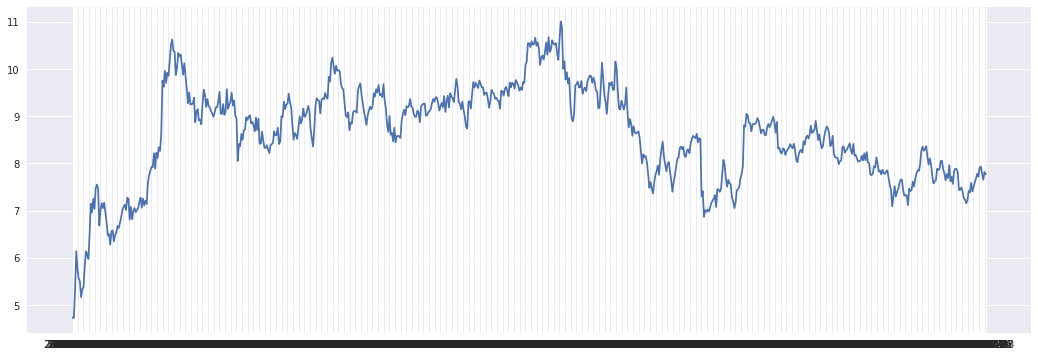

In [18]:
# create cointegrated portfolio
pf = (res.evec[:,0] * log_prices[[s1,s2,s3,s4]]).sum(axis=1)
plt.figure(figsize=(18,6))
plt.plot(pf)

In [19]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(pf)

(-4.0222338034775404,
 0.0012984603984282743,
 1,
 751,
 {'1%': -3.4390874066174355,
  '5%': -2.8653962034740705,
  '10%': -2.568823449196012},
 -240.81914629413973)

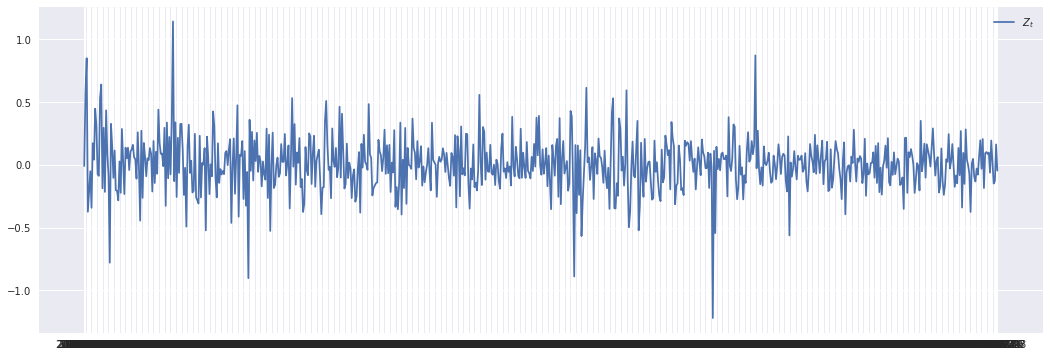

In [20]:
b = res.evec[:,0]
Z = (b * log_returns[[s1,s2,s3,s4]]).sum(axis=1)

plt.figure(figsize=(18,6))
plt.plot(Z, label=r'$Z_t$')
plt.legend()

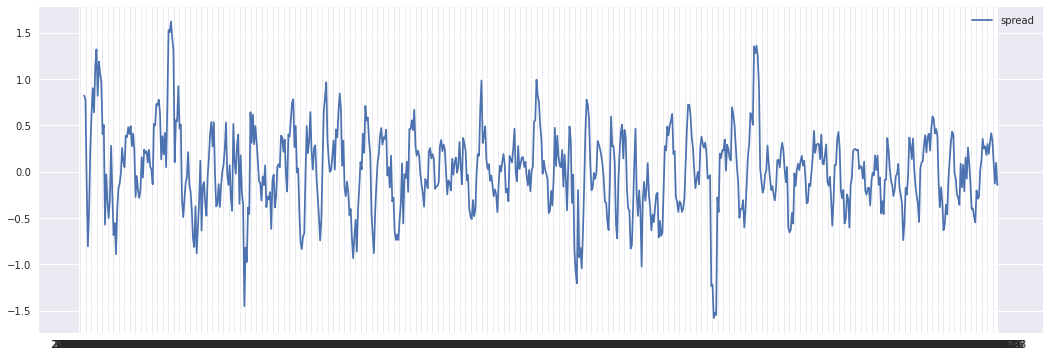

In [21]:
P = 5 # max lag parameter
spread = Z.rolling(P).sum()

plt.figure(figsize=(18,6))
plt.plot(spread, label='spread')
plt.legend()

In [22]:
weights = res.evec[:,0]
weights[weights>0] /= sum(weights[weights>0])
weights[weights<0] /= sum(abs(weights[weights<0]))
weights

array([ 1.        , -0.26603735, -0.04026545, -0.69369721])

In [23]:
spread = spread.dropna()
positions = pd.DataFrame(index=spread.index, columns=[s1,s2,s3,s4])
positions[spread>0] = -weights # short position
positions[spread<0] = weights # long position

In [24]:
ret_is = (positions.shift() * returns[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital

In [35]:
cumret_is = np.nancumprod(ret_is+1)
# cumulative returns of each stock
cumret_all = (prices.pct_change().dropna() + 1).cumprod(axis=0)
# cumulative returns of buy and hold strategy
cumret_bnh = (1/4 * cumret_all[[s1,s2,s3,s4]]).sum(axis=1)
# simple returns of buy and hold strategy
ret_bnh = cumret_bnh.pct_change().dropna()

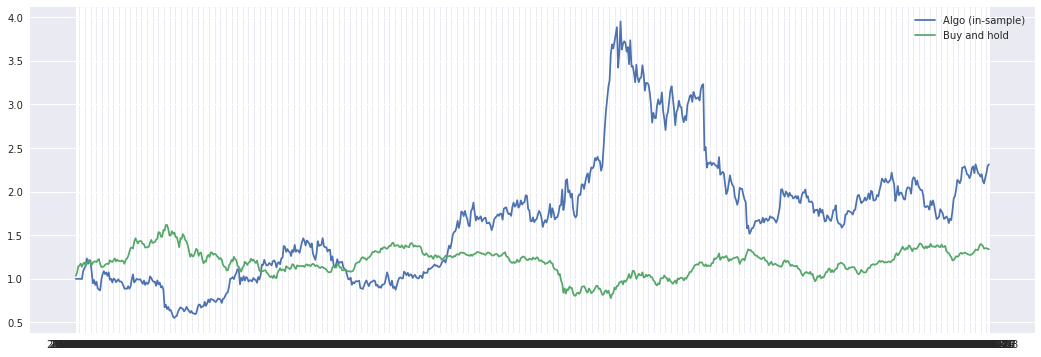

In [36]:
plt.figure(figsize=(18,6))
plt.plot(cumret_is, label='Algo (in-sample)')
plt.plot(cumret_bnh, label='Buy and hold')
plt.legend()

In [37]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [38]:
def shuffle_positions(positions_df):
    
    positions = positions_df.copy().values
    
    # shuffle positions within each column
    for col in range(positions.shape[1]):
        split =  np.split(positions[:,col], np.where((np.diff(positions[:,col]) != 0))[0]+1)
        pos = [x for x in split if x[0]!=0] # all non-zero positions
        pos_length = sum([len(x) for x in pos]) # total length in days
        zero_length = len(positions[:,col]) - pos_length
        pos += np.split(np.array([0]*zero_length), np.arange(1,zero_length))
        random.shuffle(pos)
        pos = np.concatenate(pos).astype(int)
        positions[:,col] = pos
    # shuffle columns
    np.random.shuffle(np.transpose(positions))
    
    shuffled_df = pd.DataFrame(positions, index=positions_df.index, columns=positions_df.columns)
    
    return shuffled_df

In [39]:
bootstrap_trs = [] # total returns
N = 5000 # number of random tests

for _ in range(N):
    positions_bootstrap = shuffle_positions(positions)
    ret = (positions_bootstrap.shift() * returns[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
    cumret_bootstrap = np.nancumprod(ret+1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [41]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s1])
pct_beaten = 'NA'
results_df.loc[s1] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s2])
results_df.loc[s2] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s3])
results_df.loc[s3] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s4])
results_df.loc[s4] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_bnh)
results_df.loc['Buy and hold'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [42]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_is)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (in-sample)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [43]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
ZION,0.540337,0.155769,0.554798,-0.542741,676.0,NA
NUAN,0.345846,0.104656,0.454348,-0.358292,222.0,NA
KBH,0.127163,0.040929,0.349684,-0.718545,676.0,NA
SNV,0.165901,0.052783,0.362195,-0.735993,679.0,NA
Buy and hold,0.294045,0.090222,0.420639,-0.518647,676.0,NA
Algo (in-sample),1.312892,0.324435,0.763096,-0.615949,303.0,90.6


In [46]:
def calculate_metrics_add(ret):
    '''
    calculate performance metrics from returns
    '''
    best_day = np.max(ret)
    worst_day = np.min(ret)
    pct_days_up = len(ret[ret>0]) / len(ret)
    pct_days_down = len(ret[ret<0]) / len(ret)
    avg_daily_gain = np.mean(ret[ret>0])
    sd_pos_ret = np.std(ret[ret>0])
    avg_daily_loss = np.mean(ret[ret<0])
    sd_neg_ret = np.std(ret[ret<0])
    
    return best_day, worst_day, pct_days_up, pct_days_down, avg_daily_gain, sd_pos_ret, avg_daily_loss, sd_neg_ret

In [47]:
metrics = ['Best day', 'Worst day', 'Percentage of up days', 'Percentage of down days', 
           'Average daily gain', 'SD of positive returns', 'Average daily loss', 
           'SD of negative returns']

results_add_df = pd.DataFrame(index=metrics, columns=['Algo (in-sample)', 'Buy and hold', s1,s2,s3,s4])

In [48]:
results_add_df['Algo (in-sample)'] = calculate_metrics_add(ret_is)
results_add_df['Buy and hold'] = calculate_metrics_add(ret_bnh)
results_add_df[s1] = calculate_metrics_add(returns[s1])
results_add_df[s2] = calculate_metrics_add(returns[s2])
results_add_df[s3] = calculate_metrics_add(returns[s3])
results_add_df[s4] = calculate_metrics_add(returns[s4])

In [49]:
results_add_df

,Algo (in-sample),Buy and hold,ZION,NUAN,KBH,SNV
Best day,0.143692,0.077258,0.112000,0.092544,0.163997,0.122257
Worst day,-0.234903,-0.115400,-0.108768,-0.129885,-0.154363,-0.172185
Percentage of up days,0.519947,0.488682,0.501330,0.486702,0.464096,0.464096
Percentage of down days,0.473404,0.511318,0.492021,0.497340,0.525266,0.464096
Average daily gain,0.031252,0.017959,0.020515,0.018223,0.029202,0.028073
SD of positive returns,0.025735,0.015161,0.018490,0.016502,0.025029,0.021982
Average daily loss,-0.030150,-0.015992,-0.018930,-0.016445,-0.024250,-0.026272
SD of negative returns,0.029540,0.014711,0.017085,0.015563,0.021377,0.020996


In [112]:
corr_df = pd.DataFrame(index=[s1,s2,s3,s4], columns=['Algo (in-sample)'])

for s in corr_df.index:
    corr_df.loc[s] = np.corrcoef(returns[s], ret_is)[0,1]
    
corr_df

,Algo (in-sample)
ZION,-0.032682
NUAN,0.014229
KBH,-0.019171
SNV,0.00693


In [114]:
returns[[s1,s2,s3,s4]].corr()

,ZION,NUAN,KBH,SNV
ZION,1.000000,0.496608,0.485559,0.647817
NUAN,0.496608,1.000000,0.425467,0.408890
KBH,0.485559,0.425467,1.000000,0.432189
SNV,0.647817,0.408890,0.432189,1.000000


# Out-of-sample test

In [118]:
combs = []

# save all possible quadruplets
for c in combinations(stocks, 4):
    combs.append(c)

# convert to dataframe
combs = np.array(combs)
combs = pd.DataFrame(combs, columns=['s1','s2','s3','s4'])

In [128]:
index = list(combs.index)

num_pfs = 1 # number of portfolios to select
selected_quad = []
selected_stocks = []

while len(selected_quad)<num_pfs and len(index)>0:
    i = random.choice(index) # choose random quadruplet
    s1,s2,s3,s4 = combs.loc[i] # parse stocks in quadruplet
    index.remove(i) # remove processed row
    
    try:
        res = coint_johansen(log_prices_form[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    except:
        continue
    
    if sum(res.lr2 > res.cvm[:,-2]) == 4: # if null is rejected at 95% level
        print(f'{s1}-{s2}-{s3}-{s4}')
        selected_quad.append([s1,s2,s3,s4])
        selected_stocks.extend([s1,s2,s3,s4])

        # remove all quadruplets containing already selected stocks
        for s in [s1,s2,s3,s4]:
            for c in combs.columns:
                combs = combs.loc[~(combs[c]==s)]
                index = list(set(index).intersection(set(combs.index)))

        print(f'{len(index)} items left')

LPX-ZION-PBCT-TGNA
3587 items left


In [62]:
s1,s2,s3,s4 = 'LPX','ZION','PBCT','TGNA'

In [63]:
W = 504 # window size
P = 5 # max lag parameter

positions_oos = pd.DataFrame(index=returns_trade.index, columns=[s1,s2,s3,s4])

for t in log_prices_trade.index:
    # prepare data
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-W:]
    log_returns_tmp = log_returns.loc[:t]
    log_returns_tmp = log_returns_tmp.iloc[-W:]
    
    # estimate cointegration vector
    res = coint_johansen(log_prices_tmp[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    max_eval = res.ind[0] # maximum eigenvalue index
    b = res.evec[:,max_eval] # cointegration vector
    
    # calculate spread
    Z = (b * log_returns_tmp[[s1,s2,s3,s4]]).sum(axis=1)
    spread = Z.rolling(P).sum()
    
    # calculate weights
    weights = res.evec[:,max_eval]
    weights[weights>0] /= sum(weights[weights>0])
    weights[weights<0] /= sum(abs(weights[weights<0]))
    
    if spread.iloc[-1] > 0:
        positions_oos.loc[t] = -weights
    else:
        positions_oos.loc[t] = weights

In [64]:
ret_oos = (positions_oos.shift() * returns_trade[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
cumret_oos = np.nancumprod(ret_oos+1)

In [65]:
# cumulative returns of each stock
cumret_all = (prices_trade.pct_change().dropna() + 1).cumprod(axis=0)
# cumulative returns of buy and hold strategy
cumret_bnh = (1/4 * cumret_all[[s1,s2,s3,s4]]).sum(axis=1)
# simple returns of buy and hold strategy
ret_bnh = cumret_bnh.pct_change().dropna()

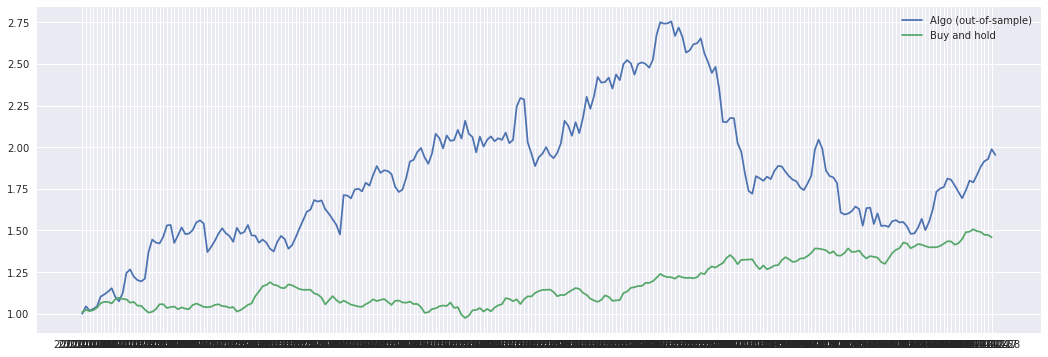

In [66]:
plt.figure(figsize=(18,6))
plt.plot(cumret_oos, label='Algo (out-of-sample)')
plt.plot(cumret_bnh, label='Buy and hold')
plt.legend()

In [67]:
bootstrap_trs = [] # total returns
N = 5000 # number of random tests

for _ in range(N):
    positions_bootstrap = shuffle_positions(positions_oos)
    ret = (positions_bootstrap.shift() * returns_trade[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
    cumret_bootstrap = np.nancumprod(ret+1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [68]:
# cumulative returns of each stock
cumret_all = (prices_trade.pct_change().dropna() + 1).cumprod(axis=0)

results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s1])
pct_beaten = 'NA'
results_df.loc[s1] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s2])
results_df.loc[s2] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s3])
results_df.loc[s3] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s4])
results_df.loc[s4] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_bnh)
results_df.loc['Buy and hold'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_oos)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (out-of-sample)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [69]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
LPX,1.238842,1.268136,2.145998,-0.205534,63.0,NA
ZION,0.235333,0.239552,0.864399,-0.221754,196.0,NA
PBCT,-0.041452,-0.042106,-0.165976,-0.148550,240.0,NA
TGNA,0.353865,0.360497,1.207635,-0.216646,99.0,NA
Buy and hold,0.444856,0.453458,1.751181,-0.180527,103.0,NA
Algo (out-of-sample),0.953419,0.969242,1.496835,-0.462610,88.0,94.4


In [73]:
metrics = ['Best day', 'Worst day', 'Percentage of up days', 'Percentage of down days', 
           'Average daily gain', 'SD of positive returns', 'Average daily loss', 
           'SD of negative returns']

results_add_df = pd.DataFrame(index=metrics, columns=['Algo (out-of-sample)','Buy and hold',s1,s2,s3,s4])

results_add_df['Algo (out-of-sample)'] = calculate_metrics_add(ret_oos)
results_add_df['Buy and hold'] = calculate_metrics_add(ret_bnh)
results_add_df[s1] = calculate_metrics_add(returns_trade[s1])
results_add_df[s2] = calculate_metrics_add(returns_trade[s2])
results_add_df[s3] = calculate_metrics_add(returns_trade[s3])
results_add_df[s4] = calculate_metrics_add(returns_trade[s4])

In [74]:
results_add_df

,Algo (out-of-sample),Buy and hold,LPX,ZION,PBCT,TGNA
Best day,0.160179,0.041433,0.070787,0.104966,0.025244,0.063637
Worst day,-0.112896,-0.043671,-0.078749,-0.075472,-0.038831,-0.076463
Percentage of up days,0.526104,0.550607,0.578313,0.550201,0.493976,0.510040
Percentage of down days,0.469880,0.449393,0.421687,0.433735,0.485944,0.457831
Average daily gain,0.028199,0.012002,0.021911,0.014171,0.008404,0.014892
SD of positive returns,0.024825,0.008836,0.015322,0.012454,0.005944,0.012011
Average daily loss,-0.024539,-0.011155,-0.021252,-0.015122,-0.008576,-0.013327
SD of negative returns,0.021590,0.008636,0.017310,0.012836,0.007707,0.012593


In [75]:
corr_df = pd.DataFrame(index=[s1,s2,s3,s4], columns=['Algo (out-of-sample)'])

for s in corr_df.index:
    corr_df.loc[s] = np.corrcoef(returns_trade[s], ret_oos)[0,1]
    
corr_df

,Algo (out-of-sample)
LPX,0.004487
ZION,-0.021921
PBCT,0.002967
TGNA,-0.24051


In [139]:
returns_trade[[s1,s2,s3,s4]].corr()

,LPX,ZION,PBCT,TGNA
LPX,1.000000,0.396623,0.371217,0.394005
ZION,0.396623,1.000000,0.572434,0.335487
PBCT,0.371217,0.572434,1.000000,0.198365
TGNA,0.394005,0.335487,0.198365,1.000000
